In [1]:
import os
import sys
project_dir = os.path.dirname(os.getcwd())
sys.path.append(project_dir)

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = torch.Generator().manual_seed(42)
print(device)

cuda


In [3]:
from utils.pipeline import train_val
from utils.plots import plot_training_metrics
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from utils.losses import Accuracy

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Ingestion

In [4]:
from data.cifar10 import get_cifar10_pipeline

train_loader, val_loader, test_loader = get_cifar10_pipeline(batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [5]:
import torch
import torch.optim as optim
import models.resnet as resnet
from utils.summary import get_model_stats

teacher = resnet.resnet34(num_classes=10).to(device)
student = resnet.resnet50(num_classes=10).to(device)

# note batch size and input shape influence FLOPS and params
sample = torch.randn(16, 3, 32, 32).to(device)
with torch.no_grad():
    print("Teacher model stats:")
    pred = teacher(sample)
    for name, param in get_model_stats(teacher, sample.shape).items():
        print(f"{name}: {param}")
    print("Student model stats:")
    pred = teacher(sample)
    for name, param in get_model_stats(student, sample.shape).items():
        print(f"{name}: {param}")

Teacher model stats:


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)


flops: 1198694400
params: 21289802
Student model stats:


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)


flops: 1342193664
params: 23528522


# Train Teacher

In [6]:
from configs.config import Config


/home/dodogama/code/project_compression/utils/pipeline.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_val_acc = torch.load(path)['accuracy']


evaluating...: 100%|██████████| 313/313 [00:06<00:00, 45.87it/s]
Epoch 10: Early stop triggered.


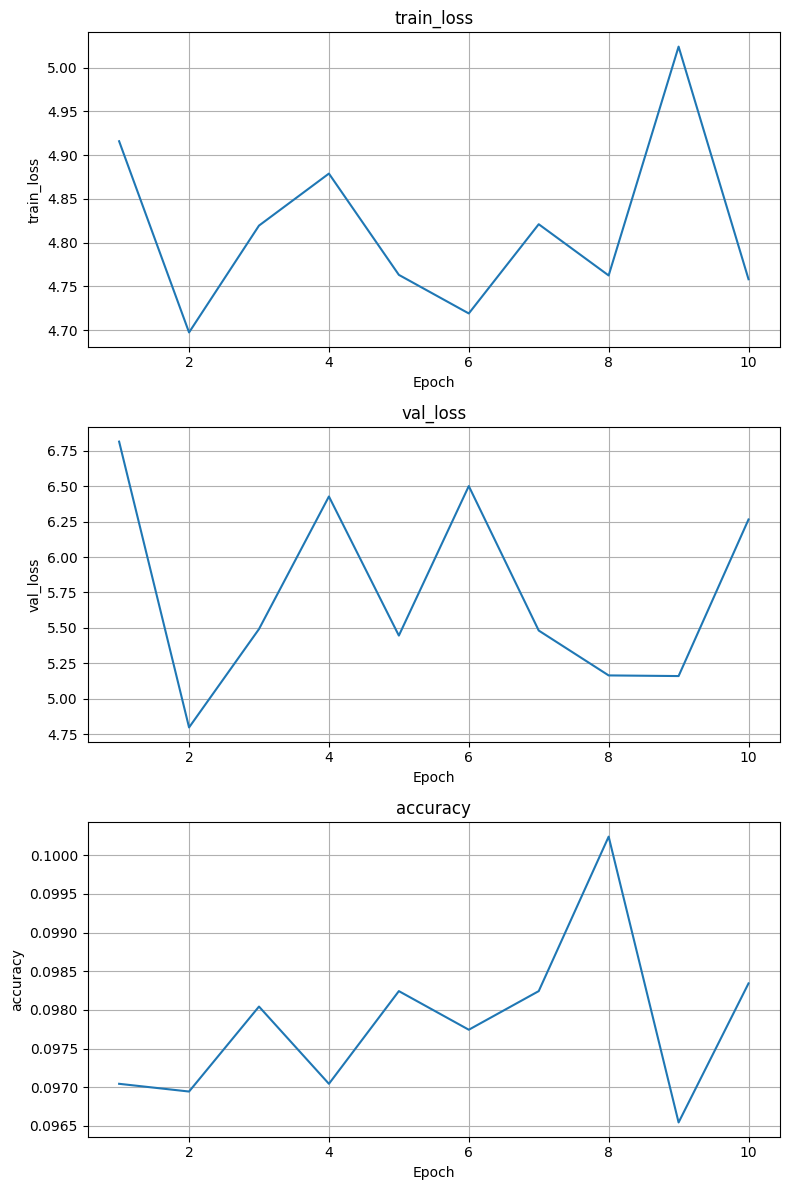

In [7]:
from utils.pipeline import train_val


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.05)
aux_metrics = {'accuracy': Accuracy()}
teacher_path = '../models/weights/resnet34.pth'

metrics = train_val(train_loader, val_loader, teacher, criterion, optimizer, scheduler, device, aux_metrics, teacher_path)
plot_training_metrics(metrics)

# Distill Student

In [8]:
from utils.pipeline import distill
from utils.losses import DistillationLoss

T = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
student_path = f'../models/weights/resnet50.pth'
teacher.load_state_dict(torch.load(teacher_path, map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, T, criterion, optimizer, scheduler, device, aux_metrics, student_path)
plot_training_metrics(metrics)

/home/dodogama/anaconda3/envs/stock_ts/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_166310/3724275065.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where 

NameError: name 'T' is not defined

# Self Distill

In [ ]:
teacher = resnet.resnet34(num_classes=10).to(device)
student = resnet.resnet34(num_classes=10).to(device)
teacher.load_state_dict(torch.load(teacher_path, map_location=device)['state_dict'])

T = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
student_path = f'../models/weights/resnet34_self_distill.pth'
teacher.load_state_dict(torch.load(teacher_path, map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, T, criterion, optimizer, scheduler, device, aux_metrics, student_path)
plot_training_metrics(metrics)